In [402]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
# load co-occurrence graph
import torch
import torch.optim as optim

class CoOccurrenceGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU):
        """
        GNN for learning ingredient embeddings from co-occurrence graphs.

        Parameters:
        - input_dim: Dimensionality of input node features.
        - hidden_dim: Dimensionality of hidden layers.
        - output_dim: Dimensionality of output node embeddings.
        """
        super(CoOccurrenceGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.activation = activation()

    def forward(self, x, edge_index, edge_attr=None):
        """
        Forward pass for the GNN.

        Parameters:
        - x: Node features (num_nodes, input_dim).
        - edge_index: Graph connectivity (2, num_edges).
        - edge_attr: Edge weights (num_edges).

        Returns:
        - Node embeddings (num_nodes, output_dim).
        """
        # First GCN layer
        x = self.conv1(x, edge_index, edge_weight=edge_attr)
        x = self.activation(x)

        # Second GCN layer
        x = self.conv2(x, edge_index, edge_weight=edge_attr)
        return x

class CoOccurrenceGNNV2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_dim, activation=nn.ReLU, dropout_rate=0.3):
        """
        Improved GNN for learning embeddings from co-occurrence graphs.

        Parameters:
        - input_dim: Dimensionality of input node features.
        - hidden_dim: Dimensionality of hidden layers.
        - output_dim: Dimensionality of output embeddings.
        - edge_dim: Dimensionality of edge attributes.
        - activation: Activation function to use (default: ReLU).
        - dropout_rate: Dropout rate to apply (default: 0.3).
        """
        super(CoOccurrenceGNNV2, self).__init__()
        
        # Graph Attention Layers
        self.conv1 = GATConv(input_dim, hidden_dim, edge_dim=edge_dim)
        self.conv2 = GATConv(hidden_dim, output_dim, edge_dim=edge_dim)
        
        # Batch Normalization
        self.bn1 = BatchNorm(hidden_dim)
        self.bn2 = BatchNorm(output_dim)
        
        # Activation
        self.activation = activation()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Residual connection
        self.residual = input_dim == output_dim  # Add residual connection only if dimensions match

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass for the GNN.
        """
        # First GAT Layer
        x1 = self.conv1(x, edge_index, edge_attr=edge_attr)
        x1 = self.bn1(x1)
        x1 = self.activation(x1)
        x1 = self.dropout(x1)
        
        # Second GAT Layer
        x2 = self.conv2(x1, edge_index, edge_attr=edge_attr)
        x2 = self.bn2(x2)
        
        # Residual connection (if applicable)
        if self.residual:
            x2 = x2 + x

        # normalize embeddings
        x2 = torch.nn.functional.normalize(x2, p=2, dim=-1)
        return x2

In [403]:
def train_gnn(model, train_graph, val_graph, epochs=100, learning_rate=0.01):
    """
    Train the GNN on the co-occurrence graph.

    Parameters:
    - model: GNN model.
    - graph: PyTorch Geometric graph object.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - model: Trained GNN model.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Move model and graph to the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_graph = train_graph.to(device)
    val_graph = val_graph.to(device)

    train_losses, val_losses = [], []

    # Log graph properties
    print("Graph Properties:")
    print(f"  Number of Nodes: {train_graph.x.shape}")
    print(f"  Number of Edges: {train_graph.edge_index.shape}")
    print(f"  Edge Attribute Dim: {train_graph.edge_attr.shape}")

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        out = model(train_graph.x, train_graph.edge_index, train_graph.edge_attr)

        # Compute edge prediction loss
        edge_attr_pred = (out[train_graph.edge_index[0]] * out[train_graph.edge_index[1]]).sum(dim=-1)
        train_loss = loss_fn(edge_attr_pred, train_graph.edge_attr)

        # Backpropagation and optimization
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_graph.x, val_graph.edge_index, edge_attr=val_graph.edge_attr)
            val_edge_attr_pred = (
                val_out[val_graph.edge_index[0]] * val_out[val_graph.edge_index[1]]
            ).sum(dim=1)
            val_loss = loss_fn(val_edge_attr_pred, val_graph.edge_attr)
            val_losses.append(val_loss.item())

        # Log progress
        if epoch % 5 == 0 or epoch == epochs:
            print(
                f"Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, "
                f"Val Loss: {val_loss.item():.4f}"
            )

    print("Training Complete!")
    return model, train_losses, val_losses

In [404]:
# load co-occurrence graph
import torch
from torch_geometric.transforms import RandomLinkSplit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graph = torch.load("./ingredient_graph_v3.pt", weights_only=False, map_location=device)
graph

splitter = RandomLinkSplit(is_undirected=True, num_test = 0.1, num_val = 0.1)
train_data, val_data, test_data = splitter(graph)

print("Train Data:")
print(train_data)
print("Validation Data:")
print(val_data)
print("Test Data:")
print(test_data)


Train Data:
Data(x=[199, 199], edge_index=[2, 5278], edge_attr=[5278], edge_label=[5278], edge_label_index=[2, 5278])
Validation Data:
Data(x=[199, 199], edge_index=[2, 5278], edge_attr=[5278], edge_label=[658], edge_label_index=[2, 658])
Test Data:
Data(x=[199, 199], edge_index=[2, 5936], edge_attr=[5936], edge_label=[658], edge_label_index=[2, 658])


Graph Properties:
  Number of Nodes: torch.Size([199, 199])
  Number of Edges: torch.Size([2, 5278])
  Edge Attribute Dim: torch.Size([5278])
Epoch 5/150, Train Loss: 0.1018, Val Loss: 0.3201
Epoch 10/150, Train Loss: 0.0778, Val Loss: 0.3233
Epoch 15/150, Train Loss: 0.0781, Val Loss: 0.3231
Epoch 20/150, Train Loss: 0.0767, Val Loss: 0.3184
Epoch 25/150, Train Loss: 0.0667, Val Loss: 0.3127
Epoch 30/150, Train Loss: 0.0616, Val Loss: 0.3034
Epoch 35/150, Train Loss: 0.0540, Val Loss: 0.2841
Epoch 40/150, Train Loss: 0.0545, Val Loss: 0.2573
Epoch 45/150, Train Loss: 0.0523, Val Loss: 0.2137
Epoch 50/150, Train Loss: 0.0503, Val Loss: 0.1776
Epoch 55/150, Train Loss: 0.0486, Val Loss: 0.1382
Epoch 60/150, Train Loss: 0.0500, Val Loss: 0.0998
Epoch 65/150, Train Loss: 0.0487, Val Loss: 0.0898
Epoch 70/150, Train Loss: 0.0472, Val Loss: 0.0718
Epoch 75/150, Train Loss: 0.0464, Val Loss: 0.0773
Epoch 80/150, Train Loss: 0.0475, Val Loss: 0.0727
Epoch 85/150, Train Loss: 0.0495, Val Loss:

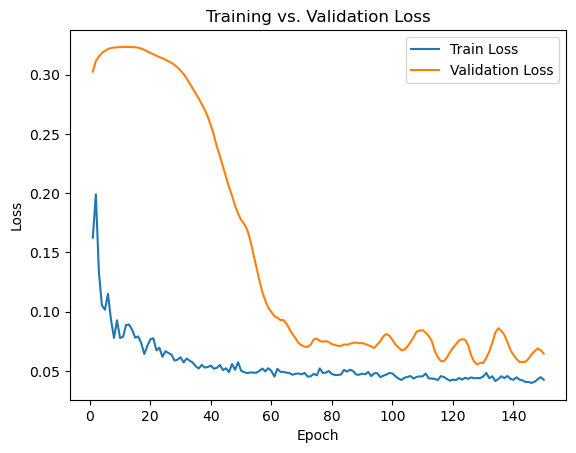

Test Loss: 0.0807


In [ ]:
import matplotlib.pyplot as plt

# Define the GNN model
input_dim = graph.x.size(1)  # Number of input features
hidden_dim = 256
output_dim = 256

edge_dim = graph.edge_attr.size(1) if graph.edge_attr is not None and graph.edge_attr.dim() > 1 else 1

# model = CoOccurrenceGNN(input_dim, hidden_dim, output_dim)
model = CoOccurrenceGNNV2(input_dim, hidden_dim, output_dim, edge_dim)

model = model.to(device)
# Train the GNN
model, train_losses, val_losses = train_gnn(model, train_data, val_data, epochs=150, learning_rate=0.01)


# Plot loss curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

def evaluate_gnn(model, test_graph):
    model.eval()
    with torch.no_grad():
        out = model(test_graph.x, test_graph.edge_index, edge_attr=test_graph.edge_attr)
        edge_attr_pred = (out[test_graph.edge_index[0]] * out[test_graph.edge_index[1]]).sum(dim=1)
        loss_fn = nn.MSELoss()
        test_loss = loss_fn(edge_attr_pred, test_graph.edge_attr)
        print(f"Test Loss: {test_loss.item():.4f}")

evaluate_gnn(model, test_data)

In [406]:
# Put the model in evaluation mode
model.eval()

# Perform a forward pass to get the ingredient embeddings
with torch.no_grad():
    ingredient_embeddings = model(graph.x, graph.edge_index, graph.edge_attr)

ingredient_embeddings.shape

torch.Size([199, 256])

In [ ]:
import torch.nn.functional as F
train_ingr_id = './utils/data/train_labels_ingr_id.csv'
# val_ingr_id = './val_labels_ingr_id.csv'
# test_ingr_id = './test_labels_ingr_id.csv'
import pandas as pd

train_df = pd.read_csv(train_ingr_id)
# ingredients name = train_df's columns name
ingredients = train_df.columns[1:-1].to_list()

# Normalize embeddings for cosine similarity
normalized_embeddings = F.normalize(ingredient_embeddings, p=2, dim=1)

# Compute pairwise similarity
similarity_matrix = normalized_embeddings @ normalized_embeddings.t()

# Find top-5 similar ingredients for a specific ingredient (e.g., ingredient 0)
ingredient_index = 0
top_k = 5
similar_indices = torch.topk(similarity_matrix[ingredient_index], top_k + 1).indices[1:]  # Exclude self
print(f"Top-{top_k} similar ingredients for ingredient {ingredient_index}: {similar_indices}")

# Print the top-5 similar ingredients
ingredient_0 = ingredients[ingredient_index]
similar_ingredients = [ingredients[i] for i in similar_indices]
print(f"Ingredient: {ingredient_0}")
print(f"Similar Ingredients: {similar_ingredients}")


Top-5 similar ingredients for ingredient 0: tensor([166,  22,   0,  54,  77])
Ingredient: brown rice
Similar Ingredients: ['ketchup', 'green beans', 'brown rice', 'cauliflower', 'chicken']


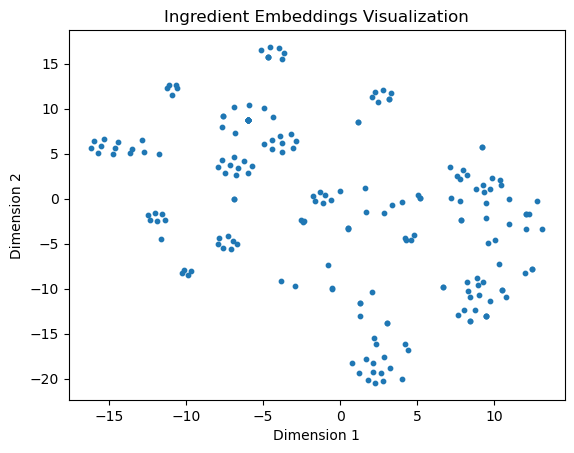

In [408]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions with t-SNE
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(ingredient_embeddings.numpy())

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Ingredient Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


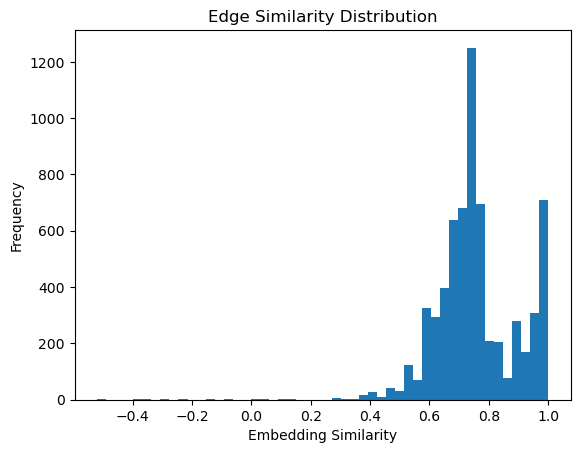

In [409]:
edge_similarity = (ingredient_embeddings[graph.edge_index[0]] * ingredient_embeddings[graph.edge_index[1]]).sum(dim=1)
plt.hist(edge_similarity.numpy(), bins=50)
plt.title("Edge Similarity Distribution")
plt.xlabel("Embedding Similarity")
plt.ylabel("Frequency")
plt.show()


ROC AUC: 0.9507
PR AUC: 0.8949


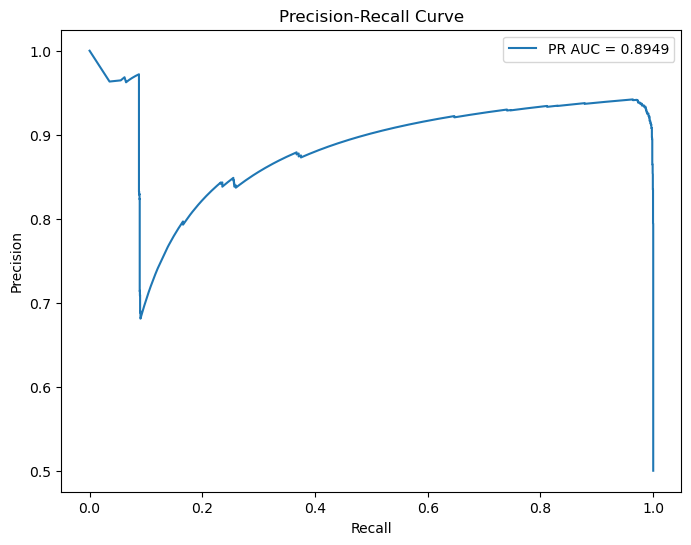

In [410]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Function to compute edge similarities
def compute_edge_similarities(embeddings, edge_index):
    node1_embeddings = embeddings[edge_index[0]]
    node2_embeddings = embeddings[edge_index[1]]
    similarities = (node1_embeddings * node2_embeddings).sum(dim=1)  # Dot product similarity
    return similarities

# Function to sample negative edges
def sample_negative_edges(num_nodes, edge_index, num_samples, device):
    negative_edges = []
    while len(negative_edges) < num_samples:
        src = torch.randint(0, num_nodes, (num_samples,), device=device)
        tgt = torch.randint(0, num_nodes, (num_samples,), device=device)
        mask = ~torch.isin(torch.stack([src, tgt], dim=0).T, edge_index.T).all(dim=1)
        negative_edges.append(torch.stack([src[mask], tgt[mask]], dim=0))
    return torch.cat(negative_edges, dim=1)[:, :num_samples]

# Function to evaluate embeddings on link prediction
def evaluate_embeddings_on_link_prediction(model, train_graph, test_graph):
    model.eval()
    
    # Get embeddings from the GNN
    with torch.no_grad():
        embeddings = model(train_graph.x, train_graph.edge_index, edge_attr=train_graph.edge_attr)

    # Compute similarity scores for test edges
    positive_scores = compute_edge_similarities(embeddings, test_graph.edge_index)

    # Generate negative edges (non-connected node pairs)
    num_nodes = train_graph.x.size(0)
    negative_edge_index = sample_negative_edges(
        num_nodes, train_graph.edge_index, test_graph.edge_index.size(1), device=embeddings.device
    )
    negative_scores = compute_edge_similarities(embeddings, negative_edge_index)

    # Combine positive and negative scores
    scores = torch.cat([positive_scores, negative_scores])
    labels = torch.cat([torch.ones_like(positive_scores), torch.zeros_like(negative_scores)])

    # Compute ROC AUC and Precision-Recall AUC
    roc_auc = roc_auc_score(labels.cpu(), scores.cpu())
    precision, recall, _ = precision_recall_curve(labels.cpu(), scores.cpu())
    pr_auc = auc(recall, precision)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    return roc_auc, pr_auc

# Example usage
roc_auc, pr_auc = evaluate_embeddings_on_link_prediction(model, train_data, test_data)
